In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth             = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive             = GoogleDrive(gauth)


In [3]:
link       = 'https://drive.google.com/file/d/1f_2LQtG2T8v7iPUV1DbP1Rh5AJ7Zc23O/view?usp=sharing'

# to get the id part of the file
id         = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train.csv')

In [4]:
df = pd.read_csv("train.csv")
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [5]:
df.dropna(inplace=True)
df.head(100)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
95,http://worldoftanks.ru/ru/content/guide/paymen...,benign
96,http://www.artedesignsas.it/catalogo.html?page...,defacement
97,en.wikipedia.org/wiki/Lloyd_Bacon,benign
98,http://serverfault.com/questions/682832/squid-...,benign


In [6]:
# Filter the dataset to include only 'benign' and 'malware' types
df = df[df['type'].isin(['benign', 'malware'])]

In [7]:
# Map 'benign' to 0 and 'malware' to 1
df['type'] = df['type'].map({'benign': 0, 'malware': 1})

<ipython-input-7-e0dccddc1a09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].map({'benign': 0, 'malware': 1})


In [8]:
# Preprocess URLs
import re
def preprocess_url(url):
    url = re.sub(r'^https?://(www\.)?', '', url)
    url = re.sub(r'/$', '', url)
    return url

df['url'] = df['url'].apply(preprocess_url)


In [9]:
# Step 3: Train the Autoencoder
X_autoencoder          = df['url']
vectorizer_autoencoder = CountVectorizer(analyzer='char')
X_autoencoder          = vectorizer_autoencoder.fit_transform(X_autoencoder)

In [10]:
# Build and train the autoencoder
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
autoencoder_model = Sequential()
autoencoder_model.add(Dense(32, input_shape=(X_autoencoder.shape[1],), activation='relu'))
autoencoder_model.add(Dense(X_autoencoder.shape[1], activation='sigmoid'))
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_model.fit(X_autoencoder.toarray(), X_autoencoder.toarray(), epochs=5 , batch_size=32, verbose=1)
# Get the encoded representations
encoded_X_autoencoder = autoencoder_model.layers[0](X_autoencoder.toarray())

Instructions for updating:
non-resource variables are not supported in the long term


Train on 460623 samples
Epoch 1/5
460623/460623 [==============================] - 15s 33us/sample - loss: 1.1272
Epoch 2/5
460623/460623 [==============================] - 18s 38us/sample - loss: 1.1195
Epoch 3/5
460623/460623 [==============================] - 23s 51us/sample - loss: 1.1189
Epoch 4/5
460623/460623 [==============================] - 14s 30us/sample - loss: 1.1187
Epoch 5/5
460623/460623 [==============================] - 14s 31us/sample - loss: 1.1184


In [11]:
# Step 4: Train the Classification Model using Encoded Features
X = X_autoencoder
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train = X_train.toarray()

model = Sequential()
model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Train on 230311 samples
Epoch 1/5
230311/230311 [==============================] - 7s 32us/sample - loss: 0.0988 - acc: 0.9741
Epoch 2/5
230311/230311 [==============================] - 6s 27us/sample - loss: 0.0712 - acc: 0.9808
Epoch 3/5
230311/230311 [==============================] - 7s 29us/sample - loss: 0.0639 - acc: 0.9826
Epoch 4/5
230311/230311 [==============================] - 6s 27us/sample - loss: 0.0597 - acc: 0.9839
Epoch 5/5
230311/230311 [==============================] - 7s 29us/sample - loss: 0.0569 - acc: 0.9844


In [12]:
MLPC = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)
MLPC.fit(X_train,y_train)

Iteration 1, loss = 0.10595373
Iteration 2, loss = 0.08908890
Iteration 3, loss = 0.08612599
Iteration 4, loss = 0.08465029
Iteration 5, loss = 0.08457965
Iteration 6, loss = 0.08316023
Iteration 7, loss = 0.08290817
Iteration 8, loss = 0.08177379
Iteration 9, loss = 0.08205076
Iteration 10, loss = 0.08136124
Iteration 11, loss = 0.08133529
Iteration 12, loss = 0.08097918
Iteration 13, loss = 0.08118321
Iteration 14, loss = 0.08067724
Iteration 15, loss = 0.07994334
Iteration 16, loss = 0.08022127
Iteration 17, loss = 0.07965717
Iteration 18, loss = 0.07957673
Iteration 19, loss = 0.07948540
Iteration 20, loss = 0.07937426
Iteration 21, loss = 0.07950102
Iteration 22, loss = 0.07913638
Iteration 23, loss = 0.07887449
Iteration 24, loss = 0.07910367
Iteration 25, loss = 0.07876440
Iteration 26, loss = 0.07895261
Iteration 27, loss = 0.07880311
Iteration 28, loss = 0.07870952
Iteration 29, loss = 0.07874032
Iteration 30, loss = 0.07870739
Iteration 31, loss = 0.07881153
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(6, 5), learning_rate_init=0.01,
              random_state=5, verbose=True)

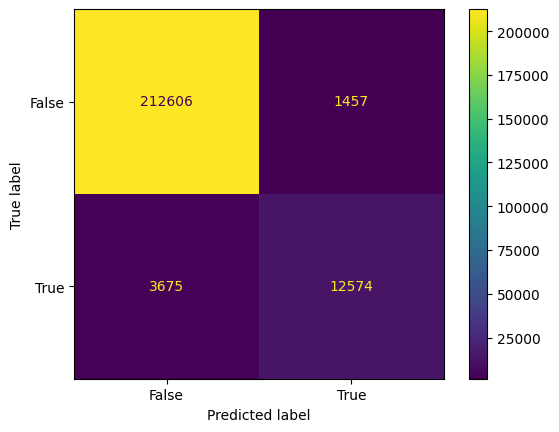

Accuracy score of MLPC classifier =  0.9777171836465317


In [16]:
# Make prediction on test dataset
y_pred=MLPC.predict(X_test)

# Import accuracy score
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

MLPC_Accuracy = accuracy_score(y_test,y_pred)
print("Accuracy score of MLPC classifier = " ,MLPC_Accuracy)


In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

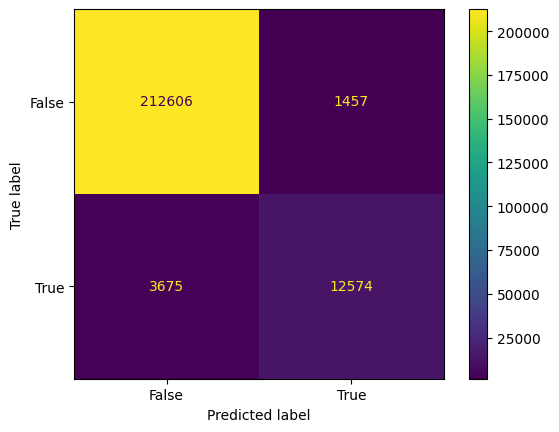

Accuracy score of K-N classifier 0.9910860050713814


In [18]:
# Make prediction on test dataset
y_pred_1 = knn1.predict(X_test)

# Import accuracy score
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

KNC_Accuracy = accuracy_score(y_test, y_pred_1)
print("Accuracy score of K-N classifier" ,KNC_Accuracy)

In [19]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=5, learning_rate=0.01, n_estimators=100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=5, ...)

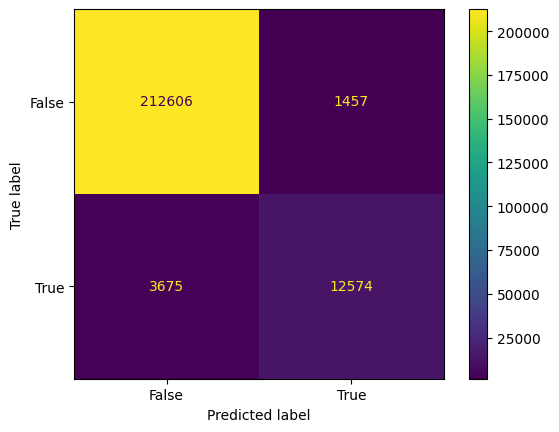

Accuracy score of X-G Boost classifier 0.9705833825419431


In [20]:
# Make prediction on test dataset
y_pred_2=model.predict(X_test)

# Import accuracy score
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
model_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
model_display.plot()
plt.show()

XGB_Accuracy= accuracy_score(y_test, y_pred_2)
print("Accuracy score of X-G Boost classifier" ,XGB_Accuracy)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(random_state=5, learning_rate=0.01, n_estimators=100)
GBC.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.01, random_state=5)

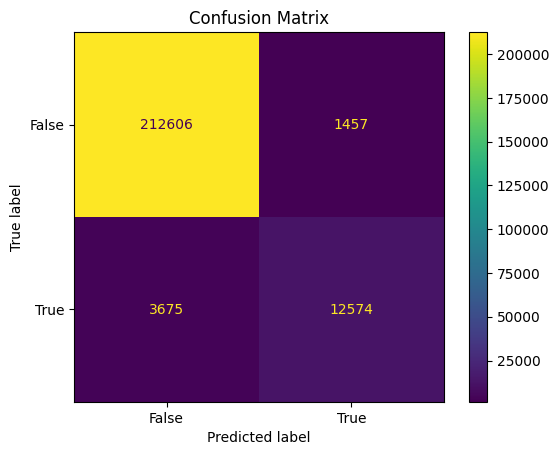

Accuracy score of Gradient Boosting Classifier = 0.960714161658967


In [23]:
y_pred_3 = GBC.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

GBC_Accuracy = accuracy_score(y_test, y_pred_3)
print("Accuracy score of Gradient Boosting Classifier =", GBC_Accuracy)

In [24]:
RF_classifier = RandomForestClassifier(n_estimators=100, max_depth=5)
RF_classifier.fit(X_train, y_train)


RandomForestClassifier(max_depth=5)

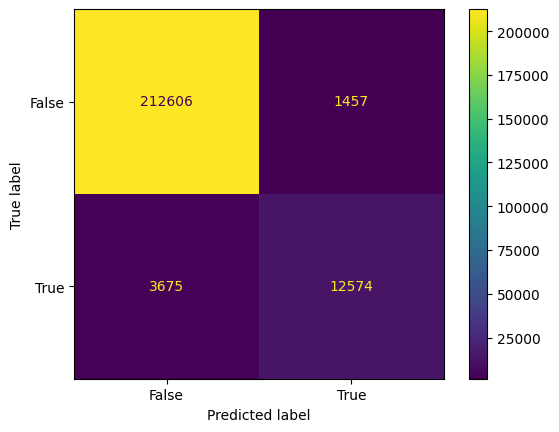

Accuracy score of Random Forest classifier: 0.9585301677724131


In [25]:
y_pred_4 = RF_classifier.predict(X_test)

# Import accuracy score
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

RF_Accuracy = accuracy_score(y_test, y_pred_4)
print("Accuracy score of Random Forest classifier:", RF_Accuracy)


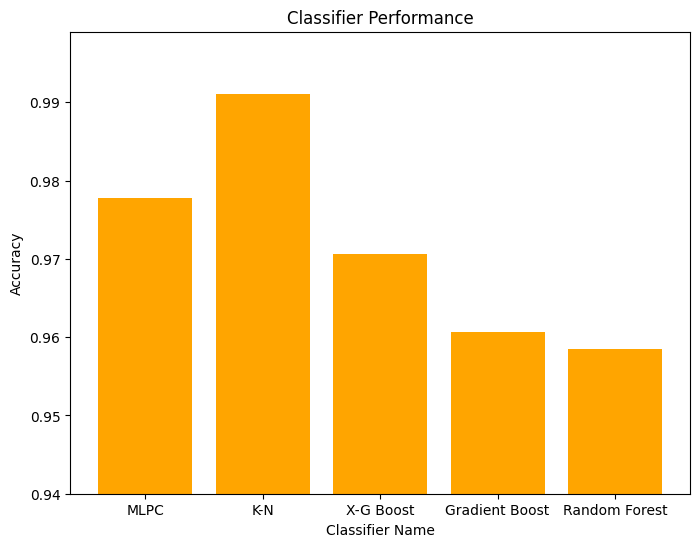

In [26]:
import matplotlib.pyplot as plt
clf_name = ["MLPC", "K-N", "X-G Boost", "Gradient Boost", "Random Forest"]
accuracy = [MLPC_Accuracy, KNC_Accuracy, XGB_Accuracy, GBC_Accuracy, RF_Accuracy]
plt.figure(figsize=(8, 6))
bars = plt.bar(clf_name, accuracy, color=['orange', 'orange', 'orange', 'orange'])
plt.xlabel("Classifier Name")
plt.ylabel("Accuracy")
plt.title("Classifier Performance")
plt.ylim(0.940, 0.999)
plt.show()



In [27]:
from tabulate import tabulate

data = [
    ["1", "MLPC", MLPC_Accuracy, ],
    ["2", "K-N", KNC_Accuracy, ],
    ["3", "X-G Boost", XGB_Accuracy ],
    ["4", "Gradient Boost", GBC_Accuracy ],
    ["5", "Random Forest", RF_Accuracy ],

]
headers = ["Serial No.", "Classifier Name", "Accuracy Score",]
table = tabulate(data, headers, tablefmt="grid")
title = "Classifier Comparison"
print(title)
print(table)


Classifier Comparison
+--------------+-------------------+------------------+
|   Serial No. | Classifier Name   |   Accuracy Score |
+==============+===================+==================+
|            1 | MLPC              |         0.977717 |
+--------------+-------------------+------------------+
|            2 | K-N               |         0.991086 |
+--------------+-------------------+------------------+
|            3 | X-G Boost         |         0.970583 |
+--------------+-------------------+------------------+
|            4 | Gradient Boost    |         0.960714 |
+--------------+-------------------+------------------+
|            5 | Random Forest     |         0.95853  |
+--------------+-------------------+------------------+


In [28]:
# Step 6: Implement URL Prediction using Autoencoder
def predict_url(url):
    preprocessed_url = preprocess_url(url)
    url_vectorized = vectorizer_autoencoder.transform([preprocessed_url])

    # Convert the sparse matrix to a sorted, ordered sparse tensor
    encoded_url = autoencoder_model.layers[0](url_vectorized.toarray())
    encoded_url_sparse = tf.sparse.reorder(tf.sparse.from_dense(encoded_url))

    prediction = model.predict(encoded_url_sparse)
    prediction_binary = (prediction > 0.5).astype(int)

    return "Malicious" if prediction_binary == 1 else "Safe"

In [29]:
# Define a list of URLs for an organization
sample_urls = [

    "signin.eby.de.zukruygxctzmmqi.civpro.co.za",
    "www.facebook.com",
    "www.pinterest.com",
    "www.twitter.com",
    "www.whatsapp.com",
    "www.yahoo.com",
    "https://jeetbuzz88.net/af/O83tN8rG/adstpopcas",
    "https://bikroy.com/",

    ]

# Initialize an empty list to store the results
results = []

# Loop through each URL in the list
for url in sample_urls:
    url_vectorized = vectorizer_autoencoder.transform([preprocess_url(url)])
    prediction = MLPC.predict(url_vectorized)[0]
    results.append((url, prediction))

# Print the results
for url, prediction in results:
    if prediction == 1:
        print(f"The URL '{url}' is classified as Malicious.")
    else:
        print(f"The URL '{url}' is classified as Safe.")


The URL 'signin.eby.de.zukruygxctzmmqi.civpro.co.za' is classified as Malicious.
The URL 'www.facebook.com' is classified as Safe.
The URL 'www.pinterest.com' is classified as Safe.
The URL 'www.twitter.com' is classified as Safe.
The URL 'www.whatsapp.com' is classified as Safe.
The URL 'www.yahoo.com' is classified as Safe.
The URL 'https://jeetbuzz88.net/af/O83tN8rG/adstpopcas' is classified as Malicious.
The URL 'https://bikroy.com/' is classified as Safe.
